In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-08 07:02:29.517286: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-08 07:02:30.876041: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-08 07:02:30.925489: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-08 07:02:30.925538: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-08 07:02:30.938678: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-08 07:02:30.938751: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-08 07:02:30.945088: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

ukdale_gen_GASF_60m_300S0X_R12_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['HEKA', 'fridge/freezer', 'HTPC', 'boiler', 'computer monitor', 'desktop computer', 'laptop computer', 'light', 'microwave', 'server computer', 'television', 'washer dryer']
{0: 0.7055908662900189, 1: 0.49534787638406874, 2: 1.3009331597222222, 3: 0.9557266755946687, 4: 1.19482978553775, 5: 1.6470766018243763, 6: 0.9269963505907095, 7: 1.3009331597222222, 8: 0.9261370658756644, 9: 3.0130176919983915, 10: 0.7942103868574457, 11: 1.2711407972858355}
 
Tests 
HEKA test: 1770 train: 7080
fridge/freezer test: 2522 train: 10085
HTPC test: 960 train: 3840
boiler test: 1307 train: 5227
computer monitor test: 1045 train: 4181
desktop computer test: 758 train: 3033
laptop computer test: 1347 train: 5389
light test: 960 train: 3840
microwave test: 1348 train: 5394
server computer test: 415 train: 1658
television test: 1572 train: 6290
washer dryer test: 983 train: 3930


In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/CNN/ukdale/TL/ukdale_12_refit, iawe, eco, redd_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data ukdale training on model refit seed 12
reading data, printing stats: 
['HEKA', 'fridge/freezer', 'HTPC', 'boiler', 'computer monitor', 'desktop computer', 'laptop computer', 'light', 'microwave', 'server computer', 'television', 'washer dryer']
{0: 0.7055908662900189, 1: 0.49534787638406874, 2: 1.3009331597222222, 3: 0.9557266755946687, 4: 1.19482978553775, 5: 1.6470766018243763, 6: 0.9269963505907095, 7: 1.3009331597222222, 8: 0.9261370658756644, 9: 3.0130176919983915, 10: 0.7942103868574457, 11: 1.2711407972858355}
 
Tests 
HEKA test: 1770 train: 7080
fridge/freezer test: 2522 train: 10085
HTPC test: 960 train: 3840
boiler test: 1307 train: 5227
computer monitor test: 1045 train: 4181
desktop computer test: 758 train: 3033
laptop computer test: 1347 train: 5389
light test: 960 train: 3840
microwave test: 1348 train: 5394
server computer test: 415 train: 1658
television test: 1572 train: 6290
washer dryer test: 983 train: 3930
loading model
compling TL model..


2022-02-08 07:02:43.608509: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-08 07:02:43.611332: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-08 07:02:43.611610: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-08 07:02:44.475605: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-08 07:02:44.475640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-08 07:02:44.475647: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-08 07:02:44.476253: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-08 07:02:45.072914: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-08 07:02:45.092517: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/20


2022-02-08 07:02:45.605365: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-08 07:02:46.369716: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-08 07:02:47.208131: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-08 07:02:47.974832: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


1874/1874 - 96s - loss: 1.2022 - accuracy: 0.6119
Epoch 2/20
1874/1874 - 93s - loss: 0.9047 - accuracy: 0.7030
Epoch 3/20
1874/1874 - 93s - loss: 0.8113 - accuracy: 0.7341
Epoch 4/20
1874/1874 - 92s - loss: 0.7631 - accuracy: 0.7515
Epoch 5/20
1874/1874 - 93s - loss: 0.7196 - accuracy: 0.7661
Epoch 6/20
1874/1874 - 93s - loss: 0.6892 - accuracy: 0.7761
Epoch 7/20
1874/1874 - 92s - loss: 0.6626 - accuracy: 0.7842
Epoch 8/20
1874/1874 - 91s - loss: 0.6414 - accuracy: 0.7916
Epoch 9/20
1874/1874 - 91s - loss: 0.6272 - accuracy: 0.7951
Epoch 10/20
1874/1874 - 92s - loss: 0.6060 - accuracy: 0.8013
Epoch 11/20
1874/1874 - 92s - loss: 0.5921 - accuracy: 0.8073
Epoch 12/20
1874/1874 - 92s - loss: 0.5858 - accuracy: 0.8076
Epoch 13/20
1874/1874 - 92s - loss: 0.5710 - accuracy: 0.8137
Epoch 14/20
1874/1874 - 92s - loss: 0.5554 - accuracy: 0.8187
Epoch 15/20
1874/1874 - 92s - loss: 0.5433 - accuracy: 0.8226
Epoch 16/20
1874/1874 - 92s - loss: 0.5335 - accuracy: 0.8255
Epoch 17/20
1874/1874 - 91s 

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/20
1874/1874 - 95s - loss: 1.9241 - accuracy: 0.3802
Epoch 2/20
1874/1874 - 93s - loss: 1.4680 - accuracy: 0.4889
Epoch 3/20
1874/1874 - 93s - loss: 1.3703 - accuracy: 0.5195
Epoch 4/20
1874/1874 - 93s - loss: 1.3136 - accuracy: 0.5348
Epoch 5/20
1874/1874 - 92s - loss: 1.2571 - accuracy: 0.5563
Epoch 6/20
1874/1874 - 92s - loss: 1.2258 - accuracy: 0.5702
Epoch 7/20
1874/1874 - 92s - loss: 1.2042 - accuracy: 0.5801
Epoch 8/20
1874/1874 - 93s - loss: 1.1595 - accuracy: 0.6007
Epoch 9/20
1874/1874 - 93s - loss: 1.1500 - accuracy: 0.6018
Epoch 10/20
1874/1874 - 92s - loss: 1.1128 - accuracy: 0.6168
Epoch 11/20
1874/1874 - 91s - loss: 1.1146 - accuracy: 0.6177
Epoch 12/20
1874/1874 - 92s - loss: 1.0844 - accuracy: 0.6271
Epoch 13/20
1874/1874 - 92s - loss: 1.0766 - accuracy: 0.6301
Epoch 14/20
1874/1874 - 92s - loss: 1.0649 - accuracy: 0.6321
Epoch 15/20
1874/1874 - 92s - loss: 1.0510 - accuracy: 0.6363
Epoch 16/20
1874/1874 - 92s - loss: 1.0508 - a

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/20
1874/1874 - 96s - loss: 1.8786 - accuracy: 0.4002
Epoch 2/20
1874/1874 - 92s - loss: 1.4637 - accuracy: 0.5247
Epoch 3/20
1874/1874 - 92s - loss: 1.3320 - accuracy: 0.5614
Epoch 4/20
1874/1874 - 92s - loss: 1.2343 - accuracy: 0.5873
Epoch 5/20
1874/1874 - 92s - loss: 1.1607 - accuracy: 0.6109
Epoch 6/20
1874/1874 - 92s - loss: 1.1157 - accuracy: 0.6280
Epoch 7/20
1874/1874 - 92s - loss: 1.0752 - accuracy: 0.6425
Epoch 8/20
1874/1874 - 92s - loss: 1.0427 - accuracy: 0.6518
Epoch 9/20
1874/1874 - 92s - loss: 1.0270 - accuracy: 0.6596
Epoch 10/20
1874/1874 - 92s - loss: 0.9940 - accuracy: 0.6732
Epoch 11/20
1874/1874 - 92s - loss: 0.9781 - accuracy: 0.6800
Epoch 12/20
1874/1874 - 92s - loss: 0.9570 - accuracy: 0.6825
Epoch 13/20
1874/1874 - 92s - loss: 0.9476 - accuracy: 0.6878
Epoch 14/20
1874/1874 - 92s - loss: 0.9225 - accuracy: 0.6974
Epoch 15/20
1874/1874 - 92s - loss: 0.9115 - accuracy: 0.6997
Epoch 16/20
1874/1874 - 92s - loss: 0.8936 - a

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/20
1874/1874 - 96s - loss: 2.3462 - accuracy: 0.1637
Epoch 2/20
1874/1874 - 97s - loss: 2.0996 - accuracy: 0.2881
Epoch 3/20
1874/1874 - 96s - loss: 1.8373 - accuracy: 0.4014
Epoch 4/20
1874/1874 - 96s - loss: 1.7423 - accuracy: 0.4358
Epoch 5/20
1874/1874 - 96s - loss: 1.6483 - accuracy: 0.4615
Epoch 6/20
1874/1874 - 95s - loss: 1.5454 - accuracy: 0.4864
Epoch 7/20
1874/1874 - 95s - loss: 1.5054 - accuracy: 0.5026
Epoch 8/20
1874/1874 - 95s - loss: 1.4025 - accuracy: 0.5212
Epoch 9/20
1874/1874 - 95s - loss: 1.3611 - accuracy: 0.5352
Epoch 10/20
1874/1874 - 96s - loss: 1.3385 - accuracy: 0.5420
Epoch 11/20
1874/1874 - 95s - loss: 1.3085 - accuracy: 0.5476
Epoch 12/20
1874/1874 - 95s - loss: 1.2864 - accuracy: 0.5546
Epoch 13/20
1874/1874 - 96s - loss: 1.2775 - accuracy: 0.5605
Epoch 14/20
1874/1874 - 96s - loss: 1.2703 - accuracy: 0.5624
Epoch 15/20
1874/1874 - 96s - loss: 1.2534 - accuracy: 0.5675
Epoch 16/20
1874/1874 - 95s - loss: 1.2461 - a

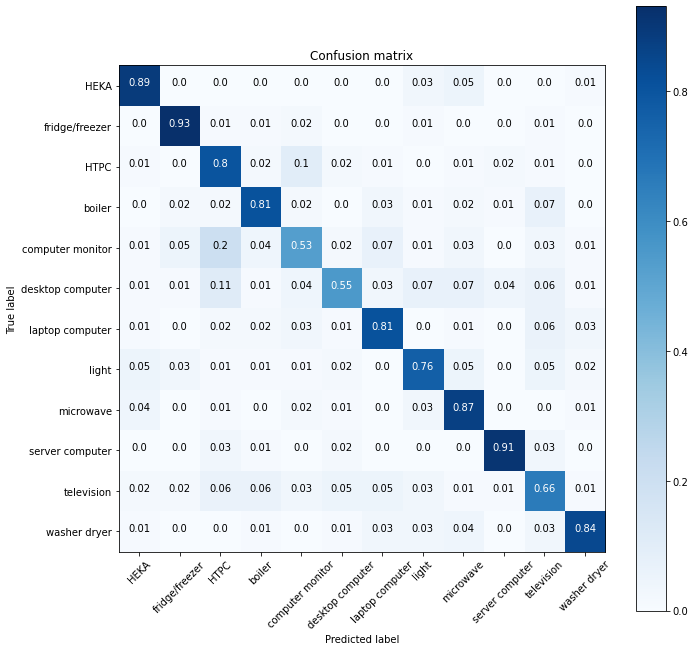

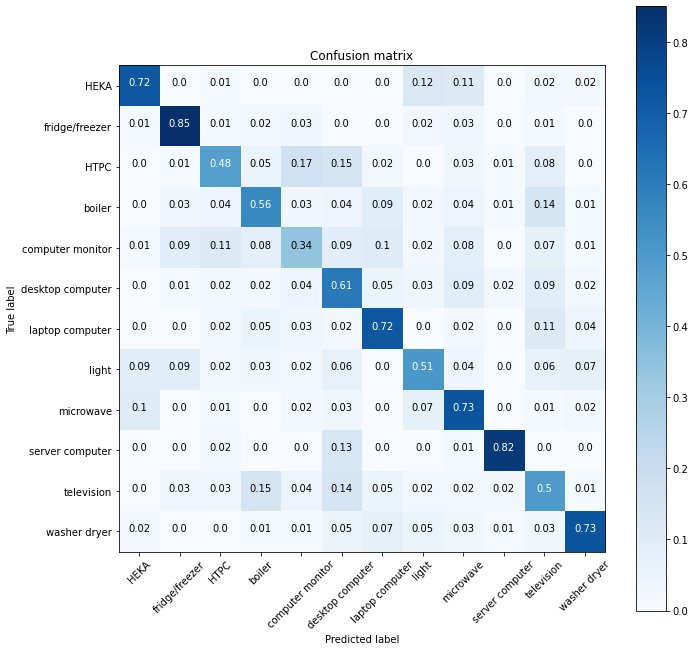

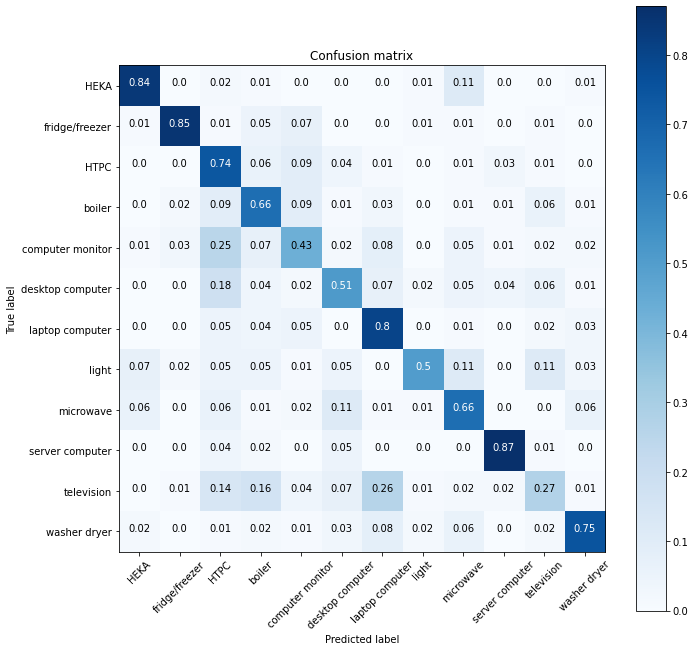

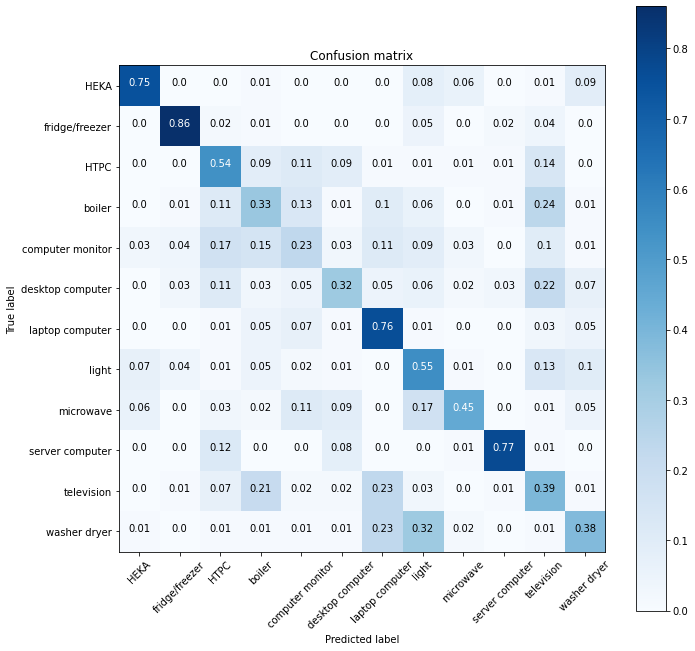

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()